# Check PCA from random inputs

Whilst I was away I realised what I _really_ should be doing is checking whether the PCs extracted in the activation space from a _typical data input distribution_ represent orthogonal components in the atypical data distribution we've created by varying our different tasks. I realised that using the latter dataset for extracting the PCs isn't very realistic because in reality both tasks are going to be varying at the same time independent of each other. 

In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
import numpy as np

from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict

In [2]:
df = pd.read_pickle("../004-multi-task/results/dfs/009-pca.pkl")
len(df)

100

### Network

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(name, "\n", param.data, "\n")

### Data

In [4]:
# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


def generate_data(n_samples=10000):
    # Epsilon value
    eps = 0.5

    # Initial generation
    Y1 = generate_Y(n_samples)
    X1 = generate_X(Y1, eps)

    # Ensure they are statistically independent by generating new Y and X values
    Y2 = generate_Y(n_samples)
    X2 = generate_X(Y2, eps)

    # Stack X1 and X2 to get the desired shape
    X = torch.cat((X1, X2), dim=1)

    # Stack Y1 and Y2 for the desired shape
    Y = torch.stack((Y1, Y2), dim=1)

    # Validate the relationship
    assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
    assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y, alpha=0.5, density=True, label="force")
    ax.legend()

### Analysis functions

In [5]:
def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(
                module, input, output, name
            )
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {
        k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2
    }
    return filtered_values

In [6]:
# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


def generate_data(n_samples=10000):
    # Epsilon value
    eps = 0.5

    # Initial generation
    Y1 = generate_Y(n_samples)
    X1 = generate_X(Y1, eps)

    # Ensure they are statistically independent by generating new Y and X values
    Y2 = generate_Y(n_samples)
    X2 = generate_X(Y2, eps)

    # Stack X1 and X2 to get the desired shape
    X = torch.cat((X1, X2), dim=1)

    # Stack Y1 and Y2 for the desired shape
    Y = torch.stack((Y1, Y2), dim=1)

    # Validate the relationship
    assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
    assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y, alpha=0.5, density=True, label="force")
    ax.legend()


def get_inputs(N=100, vary_task="A"):
    """Get inputs where one task is varied and the other is fixed."""
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs


def get_pcs(data):
    """Produce principal components and variances for a dataset."""
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances


def get_os(vectors):
    """Get orthogonality scores for a set of vectors."""
    angles = np.arctan2(vectors[..., 1], vectors[..., 0])
    os = np.abs(
        (np.mod(angles, np.pi / 2) - np.pi / 4) / (np.pi / 4)
    )  # I'm sure there's a neater way of doing this...
    return os


def get_sims(pcsA, pcsB):
    """Get the similarity matrix between two sets of principal components."""
    return torch.matmul(pcsA.T, pcsB).numpy()


def compute_variances(pcs, acts, indices):
    return torch.stack(
        [torch.var((pcs[:, i] * acts[indices]).sum(-1)) for i in range(16)]
    )


def plot_similarity(
    sims, title="Dot-product Similarity of\nPrincipal Components", x_label=None
):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel("Combined Tasks", fontsize=14)


def plot_pca_variances(varA, varB, err_varA=None, err_varB=None):
    _, ax = plt.subplots(figsize=(6, 6))

    # plot the variances for task A
    ax.bar(range(len(varA)), varA, yerr=err_varA, label="Task A activations", alpha=0.5)
    ax.bar(range(len(varB)), varB, yerr=err_varB, label="Task B activations", alpha=0.5)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance")
    ax.set_title("Variance of Principal Components from Task A")
    ax.legend()

### Get PCs

In [7]:
(
    X_train,
    Y_train,
    X_valid,
    Y_valid,
) = generate_data()  # this is a typical input distribution
inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)  # this is the task separated input distribution

rows = []
for i, row in tqdm(df.iterrows()):
    model = Net(input_dim=4, hidden_dim=16, output_dim=2)
    model.load_state_dict(row.model)
    model.eval()

    sep_ios = capture_intermediate_outputs(model, inputs)
    comb_ios = capture_intermediate_outputs(model, X_valid)
    sep_acts, comb_acts = sep_ios["layers.0.act"], comb_ios["layers.0.act"]
    pcs, _ = get_pcs(
        comb_acts
    )  # principal components and variances for both tasks varied at the same time
    pcsA, _ = get_pcs(sep_acts[:10000])  # principal components and variances for task A
    pcsB, _ = get_pcs(sep_acts[10000:])  # principal components and variances for task B
    row["pcs"] = pcs
    row["pcsA"] = pcsA
    row["pcsB"] = pcsB
    row["comb_acts"] = comb_acts
    row["sep_acts"] = sep_acts
    row.pop("acts")
    rows.append(row)
df = pd.DataFrame(rows)

0it [00:00, ?it/s]

Here I am now calculating the variances explained in each task dataset by the principal components extracted from the typical input distribution (the validation set):

In [10]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)
varA = compute_variances(pcs, row["sep_acts"], sliceA).numpy()
varB = compute_variances(pcs, row["sep_acts"], sliceB).numpy()

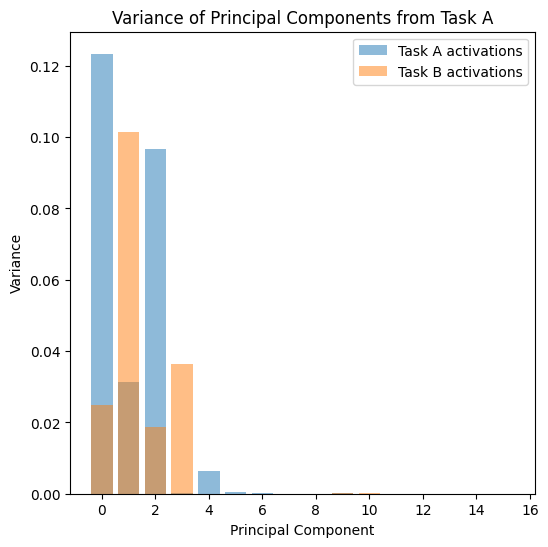

In [11]:
plot_pca_variances(varA, varB)

In [12]:
varAs, varBs = [], []
for i, row in df.iterrows():
    varA = compute_variances(row["pcs"], row["sep_acts"], sliceA).numpy()
    varB = compute_variances(row["pcs"], row["sep_acts"], sliceB).numpy()
    varAs.append(varA)
    varBs.append(varB)

varAs = np.stack(varAs)
varBs = np.stack(varBs)

In [14]:
nvarAs = varAs / np.linalg.norm(varAs, axis=1)[:, None]
nvarBs = varBs / np.linalg.norm(varBs, axis=1)[:, None]

In [15]:
Δ = np.abs(varAs - varBs)
mean_Δ = Δ.mean(0)
err_Δ = Δ.std(0) / np.sqrt(len(Δ))
mean_Δ.shape, err_Δ.shape

((16,), (16,))

Text(0.5, 1.0, 'Variance separation between tasks across PCs')

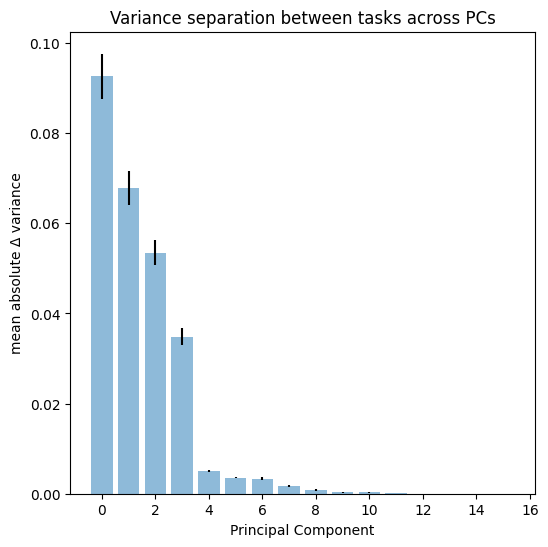

In [16]:
_, ax = plt.subplots(figsize=(6, 6))

# plot the variances for task A
ax.bar(range(len(mean_Δ)), mean_Δ, yerr=err_Δ, alpha=0.5)
ax.set_xlabel("Principal Component")
ax.set_ylabel("mean absolute Δ variance")
ax.set_title("Variance separation between tasks across PCs")

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_55275/48271130.py:2: RuntimeWarning: invalid value encountered in divide
  variance_capture = vars.max(-1) / vars.sum(-1)


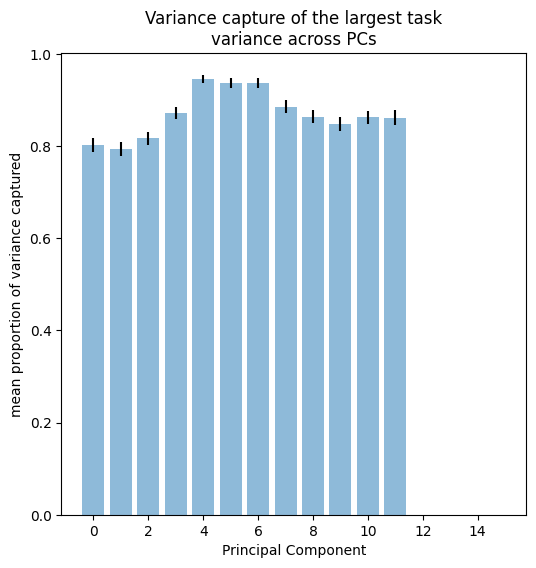

In [17]:
vars = np.concatenate((varAs[:, :, None], varBs[:, :, None]), axis=-1)
variance_capture = vars.max(-1) / vars.sum(-1)
vc_mean = variance_capture.mean(0)
vc_err = variance_capture.std(0) / np.sqrt(len(variance_capture))

_, ax = plt.subplots(figsize=(6, 6))

# plot the variances for task A
ax.bar(range(len(vc_mean)), vc_mean, yerr=vc_err, alpha=0.5)
ax.set_xlabel("Principal Component")
ax.set_ylabel("mean proportion of variance captured")
_ = ax.set_title("Variance capture of the largest task\nvariance across PCs")

Ok, this looks about the same as when I computed the variances from the PCs extracted from the individual task dataset which is good. This means: even in a real-world setting where the "tasks" are varying concurrently, we still have a chance of extracting them with a reasonable degree of precision.

I'd like to understand why we have a bump in orthogonality for the medium variance components (around 4-6 inclusive). It might be something to do with the fact that PCA gets "confused" for the high-variance components where both tasks are varying significantly and could produce more noise. 

I wonder to what extent the ~20% average interference in each component originates from:
- inherent non-orthogonality in the processing of the network
- limitations in the use of PCA to find the orthogonal components

I could test this by going back to extracting the individual task-specific PCs and plotting the same variance capture plot as above.

If PCA is too limited then this means finding orthogonal task treatment in the _parameter_ space could be worth looking at again. Following this idea: it would be an interesting experiment to see if I could train a model to regress the principal components of the activation space (therefore containing the orthogonal task processing vectors) from the parameters. If this was true then I could be more sure that at least the information was there to extract, then I could focus on a cleaner/more general means of extracting the components from the parameters (that hadn't overfit to the particular task at hand).

If there was indeed some kind of "imprint" of the task components in the parameters of the next layer, this would be a nice idea where the model has aligned itself such that there are almost "entry-points" for the task outputs of the last layer into the next layer.

### What about the little tasks?

What about the tasks that are independent, but do not produce a lot of variance (perhaps because they are less important)? I suppose these might be lost in this noisy PCA process.

### What about superposition?

What happens when we do not have enough "capacity" to model the number of tasks we need to model? It would be interesting to explore "task sparsity" and whether it leads to task superposition. I'd hypothesise that we'd start seeing the task solutions collapsing to simpler modes (as I studied in `001-f-equals-ma`) as we added more tasks, because they need to all fit into fewer dimensions.

With this in mind, I wonder if one could define the "required" dimensionality to model a certain task to a certain accuracy by studying how much of the space is occupied with high-variance components. This could then be used to help produce some kind of scaling law in the multi-task setting and to make predictions of performance.

This would be a simple experiment to set up and it'd be interesting to see if we could make some strong predictions for at what point the performance completely breaks down.